# Loadshedding Analysis
## Last Updated: 14 April 2023

In [72]:
# Module Imports
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import seaborn as sns
import matplotlib

### Get data from Eskom se Push Google Sheet

In [13]:
load_dotenv()

data_folder = '../data'
sheet_id = os.getenv("GOOGLE_SHEET_ID")
sheet_gid = os.getenv("GOOGLE_SHEET_GID")

# Check if the data folder is empty
if not os.path.exists(data_folder) or len(os.listdir(data_folder)) == 0:
    # Create the data folder if it doesn't exist
    os.makedirs(data_folder, exist_ok=True)

    # Download the CSV data
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={sheet_gid}"
    response = requests.get(url)
    response.raise_for_status()

    # Save the data to a CSV file
    csv_file_path = os.path.join(data_folder, 'loadshedding_data.csv')
    with open(csv_file_path, 'w', encoding='utf-8') as file:
        # Remove empty lines
        lines = response.text.splitlines()
        content = "\n".join(line for line in lines if line.strip())
        file.write(content)

    print("CSV file successfully downloaded.")
else:
    print("Data folder is not empty. Skipping download.")


CSV file successfully downloaded.


### Read in data and calculate GWh of loadshedding per entry

In [ ]:
# Load the data into a DataFrame
data = pd.read_csv('../data/loadshedding_data.csv')

# Convert the date column to datetime format
data['created_at'] = pd.to_datetime(data['created_at'])

# Sort the data in ascending order by date
data = data.sort_values(by='created_at')

# Calculate the MW shed for each row - assumes that the loadshedding stages corresponds to increments of 1000 MW shed
data['MW_shed'] = data['stage'] * 1000

# Calculate the duration of each load shedding stage in hours
data['duration'] = data['created_at'].diff().shift(-1)
data['duration'] = data['duration'].dt.total_seconds() / 3600

# Calculate the duration for the last row up until current point in time
current_time = datetime.now()
data.iloc[-1, data.columns.get_loc('duration')] = (current_time - data.iloc[-1]['created_at']).total_seconds() / 3600

# Calculate the GWh shed for each row
data['GWh_shed'] = data['MW_shed'] * data['duration'] / 1000

### Plot the average amount of GWh loadshed per day by year

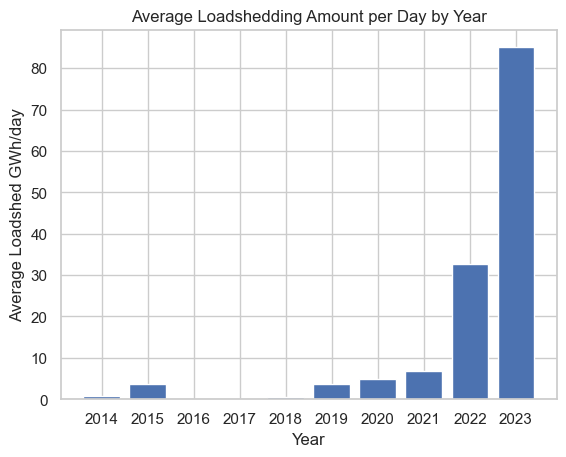

In [90]:
# Calculate the total GWh shed for each year
data['year'] = data['created_at'].dt.year
annual_gwh_shed = data.groupby('year')['GWh_shed'].sum()

# Calculate number of days in each year considering leap years
years = data['year'].unique()
days_in_year = {}

for year in years[:-1]:
    days_in_year[year] = 366 if calendar.isleap(year) else 365

# For the current year, calculate the number of days up until the current time. 
# This does assume that the final row in the data corresponds with the current year.
current_year = years[-1]
days_passed = (current_time - datetime(current_year, 1, 1)).days + (current_time - datetime(current_year, 1, 1)).seconds / 86400
days_in_year[current_year] = days_passed
days_in_year = pd.Series(days_in_year)

# Calculate GWh/day for each year
annual_gwh_per_day = annual_gwh_shed / days_in_year

# Create a new series with a range of years as the index to account for years with no loadshedding
all_years = pd.Series(index=range(data['year'].min(), data['year'].max() + 1))

# Update the series with the annual_gwh_per_day values and fill missing values with 0
all_years = all_years.combine_first(annual_gwh_per_day).fillna(0)

# Create a bar plot showing the GWh/day for each year
plt.bar(all_years.index, all_years.values)
plt.xlabel('Year')
plt.ylabel('Average Loadshed GWh/day')
plt.title('Average Loadshedding Amount per Day by Year')
plt.xticks(all_years.index)
plt.show()

### Stacked bar plot indicating the variation of Loadshedding by month and year.

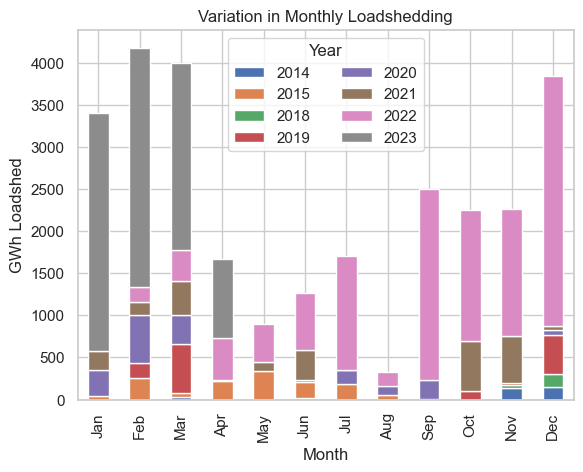

In [86]:
# Calculate the monthly GWh shed
data['month'] = data['created_at'].dt.month
monthly_gwh_shed = data.groupby(['year', 'month'])['GWh_shed'].sum().reset_index()

# Create a stacked bar plot showing the monthly variation in GWh shed
pivot_table = monthly_gwh_shed.pivot_table(values='GWh_shed', index='month', columns='year')
pivot_table.fillna(0, inplace=True)

pivot_table.plot(kind='bar', stacked=True)
plt.xlabel('Month')
plt.ylabel('GWh Loadshed')
plt.title('Variation in Monthly Loadshedding')
plt.legend(pivot_table.columns, title='Year', ncol=2)
month_names = [calendar.month_abbr[m] for m in range(1, 13)]  # Convert month numbers to month names
plt.xticks(range(0, 12), month_names)  # Set month names as x-axis labels
plt.show()

### Plot mean loadshedding stage duration by year

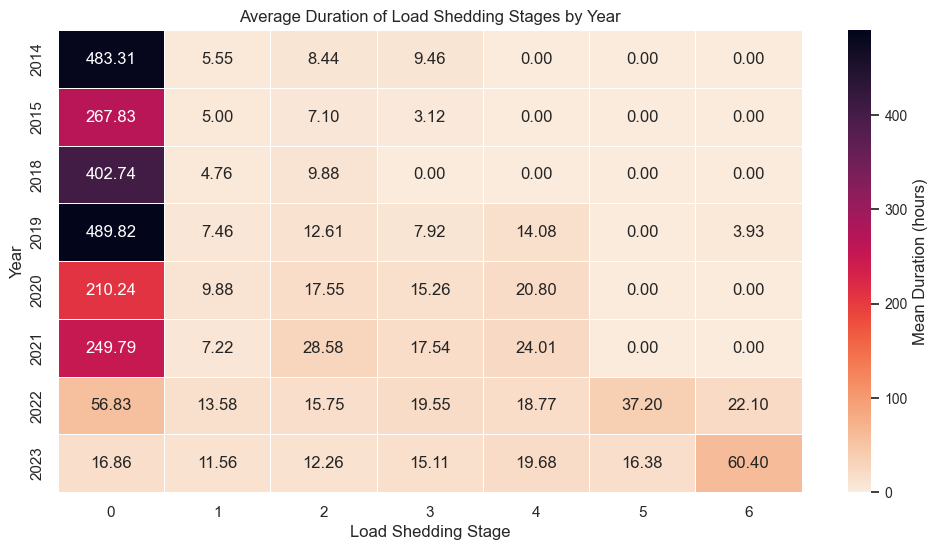

In [91]:

def plot_loadshedding_heatmap(data):
    # Set plot style and size
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    # Set a custom color map for the heatmap
    cmap = sns.cm.rocket_r

    # Create the heatmap
    ax = sns.heatmap(data, annot=True, cmap=cmap, fmt=".2f", linewidths=.5, cbar_kws={"label": "Mean Duration (hours)"})

    # Set plot labels and title
    ax.set_xlabel("Load Shedding Stage")
    ax.set_ylabel("Year")
    ax.set_title("Average Duration of Load Shedding Stages by Year")
    
    # Customize the color bar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=10)

    plt.show()


# Group the data by year and stage, then calculate the mean duration for each group
average_duration_by_year_stage = data.groupby(['year', 'stage'])['duration'].mean().reset_index()

# Pivot the table for better visualization
pivot_table = average_duration_by_year_stage.pivot_table(values='duration', index='year', columns='stage')
pivot_table.fillna(0, inplace=True)
plot_loadshedding_heatmap(pivot_table)

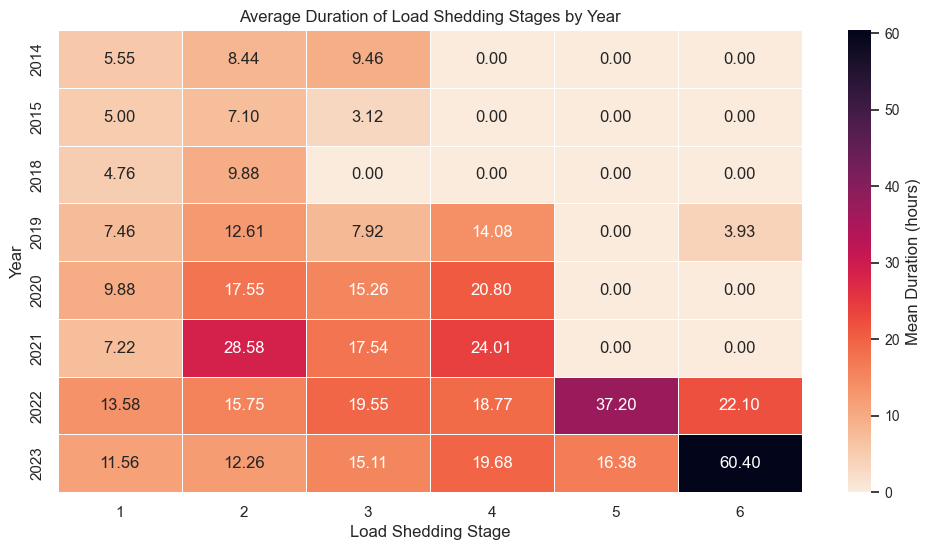

In [89]:
# Remove the Stage 0 data, as it skews the heatmap
pivot_table_no_stage0 = pivot_table.drop(columns=[0])
plot_loadshedding_heatmap(pivot_table_no_stage0)
